Simple latency measurement by incorporating:

    Memory usage comparisons (GPU or CPU)
    Accuracy measurements on a small validation set (SST-2)
    Throughput (queries per second) calculations
    Multiple runs per scenario to gather average and percentile latencies

Scenarios:

    FP32 (default, full precision on GPU if available)
    FP16 (half-precision on GPU; requires GPU support)
    Dynamic Quant (8-bit integer weights on CPU layers only)

README.md:   0%|          | 0.00/5.27k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Device set to use cuda:0
Device set to use cpu


        Scenario  Avg Latency (ms)  P50 Latency (ms)  P95 Latency (ms)  \
0           FP32        240.552743        244.652510        248.284006   
1           FP16        240.679105        236.526251        265.728426   
2  DYNAMIC_QUANT       1333.750963       1347.313404       1378.811550   

   Throughput (samples/s)  Accuracy  Memory Before (GB)  Memory After (GB)  
0              207.854624      0.98            0.278396           0.278396  
1              207.745496      0.98            0.146017           0.146017  
2               37.488258      0.96            0.009177           0.009177  


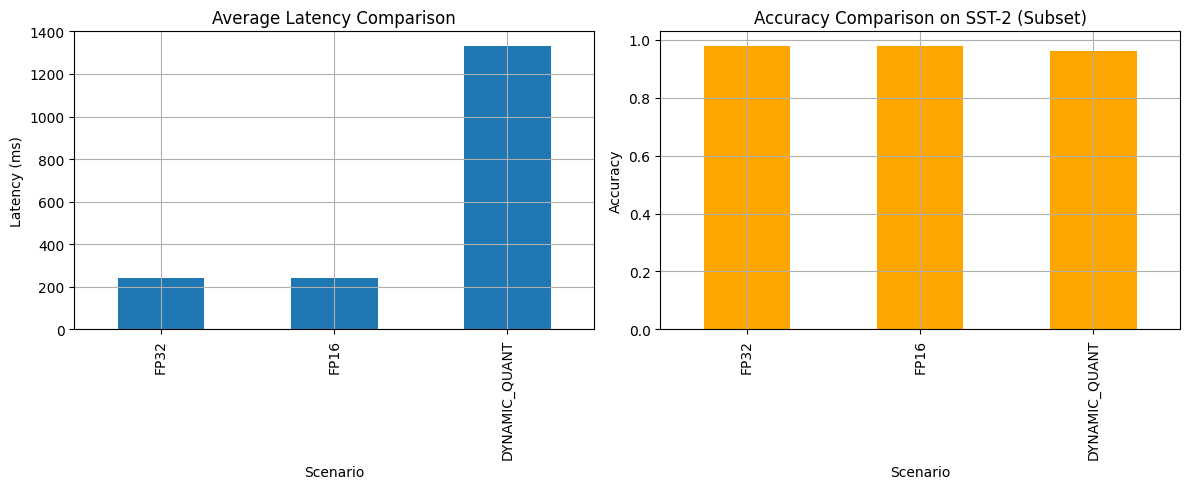

In [13]:
# ======================================================
# 1) Installation
# ======================================================
!pip install -q --upgrade pip
!pip install -q transformers torch pandas matplotlib datasets

# ======================================================
# 2) Imports
# ======================================================
import time
import statistics
import torch
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline

# We will compare three scenarios:
# 1) FP32
# 2) FP16
# 3) Dynamic Quant (CPU-only)
scenarios = ["fp32", "fp16", "dynamic_quant"]

# We'll measure:
# - Latency: average, p50, p95
# - Throughput: queries/second
# - Accuracy: On a subset of the SST-2 dataset
# - Memory usage: GPU or CPU

# We'll use the "distilbert-base-uncased-finetuned-sst-2-english" model for sentiment analysis
model_name = "distilbert-base-uncased-finetuned-sst-2-english"

# Data loading: We'll take a small subset of SST-2 for demonstration
# https://huggingface.co/datasets/stanfordnlp/sst2
dataset = load_dataset("sst2", split="validation[:50]")  # 50 examples for quick demonstration

# Helper function: Create pipeline in different precision modes
def create_pipeline(precision):
    """
    Creates a sentiment-analysis pipeline with the specified precision.
    - 'fp32': standard 32-bit float on GPU if available
    - 'fp16': half-precision on GPU (requires GPU support)
    - 'dynamic_quant': dynamic quant on CPU (int8 linear layers)
    """
    if precision == "fp16":
        # FP16 on GPU only
        model = AutoModelForSequenceClassification.from_pretrained(model_name, torch_dtype=torch.float16)
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        if torch.cuda.is_available():
            return pipeline("sentiment-analysis", model=model.to("cuda"), tokenizer=tokenizer, device=0)
        else:
            print("FP16 requested but no GPU found; defaulting to CPU.")
            return pipeline("sentiment-analysis", model=model.to("cpu"), tokenizer=tokenizer, device=-1)

    elif precision == "dynamic_quant":
        # Dynamic quantization on CPU
        model = AutoModelForSequenceClassification.from_pretrained(model_name)
        model_int8 = torch.quantization.quantize_dynamic(
            model, {torch.nn.Linear}, dtype=torch.qint8
        )
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        return pipeline("sentiment-analysis", model=model_int8, tokenizer=tokenizer, device=-1)

    else:
        # Default to FP32, GPU if available
        model = AutoModelForSequenceClassification.from_pretrained(model_name)
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        if torch.cuda.is_available():
            return pipeline("sentiment-analysis", model=model.to("cuda"), tokenizer=tokenizer, device=0)
        else:
            return pipeline("sentiment-analysis", model=model.to("cpu"), tokenizer=tokenizer, device=-1)

# ======================================================
# 3) Benchmark function
# ======================================================
def benchmark_scenario(precision, num_runs=5, batch_size=1):
    """
    1) Creates pipeline with desired precision
    2) Measures average, p50, p95 latency over multiple runs
    3) Calculates throughput = queries per second
    4) Measures memory usage (if GPU is used)
    5) Computes accuracy on a subset of SST-2

    Returns a dictionary of metrics.
    """
    # Clear GPU cache if available
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # Create pipeline
    classifier = create_pipeline(precision)

    # Memory usage before inference
    if torch.cuda.is_available():
        mem_before = torch.cuda.memory_allocated() / 1e9
    else:
        mem_before = 0.0

    # Warm-up (not measured)
    _ = classifier("warm-up test")

    # We'll measure latency for multiple runs to get p50/p95
    latencies = []
    total_samples = 0

    # For accuracy measurement, we'll do a simple loop over the dataset
    # We'll measure latencies here simultaneously
    correct = 0
    total = 0

    # We'll process dataset in chunks of batch_size
    # (though pipeline doesn't do true batched inference with `sentiment-analysis`,
    #  this could be adapted for batch inference tasks)
    texts = [ex["sentence"] for ex in dataset]
    labels = [ex["label"] for ex in dataset]

    for run in range(num_runs):
        # We'll run classification on all samples for each run
        start_time = time.time()

        # Go through our subset (50 examples).
        # This is simplistic; for real scenarios, consider actual batching or a bigger dataset.
        for text, gold_label in zip(texts, labels):
            pred = classifier(text)[0]
            pred_label = 1 if pred["label"] == "POSITIVE" else 0
            if pred_label == gold_label:
                correct += 1
            total += 1

        end_time = time.time()
        latency_ms = (end_time - start_time) * 1000

        latencies.append(latency_ms)
        total_samples += len(texts)

    # Compute accuracy
    accuracy = correct / total if total > 0 else 0.0

    # Memory usage after inference
    if torch.cuda.is_available():
        mem_after = torch.cuda.memory_allocated() / 1e9
    else:
        mem_after = 0.0

    # Summarize latencies
    avg_latency_ms = statistics.mean(latencies)
    p50_latency_ms = statistics.median(latencies)
    p95_latency_ms = statistics.quantiles(latencies, n=100)[94] if len(latencies) >= 2 else avg_latency_ms

    # Throughput: total samples / total time across runs
    total_time_s = sum(lat / 1000.0 for lat in latencies)
    throughput = (total_samples / total_time_s) if total_time_s > 0 else 0.0

    # Return summary
    return {
        "Scenario": precision.upper(),
        "Avg Latency (ms)": avg_latency_ms,
        "P50 Latency (ms)": p50_latency_ms,
        "P95 Latency (ms)": p95_latency_ms,
        "Throughput (samples/s)": throughput,
        "Accuracy": accuracy,
        "Memory Before (GB)": mem_before,
        "Memory After (GB)": mem_after
    }

# ======================================================
# 4) Run Benchmarks
# ======================================================
results = []
for scenario in scenarios:
    metrics = benchmark_scenario(scenario, num_runs=3, batch_size=1)
    results.append(metrics)

# ======================================================
# 5) Present Results
# ======================================================
df = pd.DataFrame(results)
print(df)

# Plot a couple of key metrics
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot average latency
df.plot.bar(x="Scenario", y="Avg Latency (ms)", ax=ax[0], legend=False)
ax[0].set_title("Average Latency Comparison")
ax[0].set_ylabel("Latency (ms)")
ax[0].grid(True)

# Plot accuracy
df.plot.bar(x="Scenario", y="Accuracy", ax=ax[1], legend=False, color="orange")
ax[1].set_title("Accuracy Comparison on SST-2 (Subset)")
ax[1].set_ylabel("Accuracy")
ax[1].grid(True)

plt.tight_layout()
plt.show()


P50 latency is the median latency value:

If you collect the latency for many inferences (e.g., 100 runs), sort those latencies from smallest to largest, then the P50 (50th percentile) is the one right in the middle. In other words, half the measured latencies are faster than this, and half are slower.

P95 latency is the 95th percentile latency value:

Again, with a sorted list of latencies, the P95 is the one where 95% of latency measurements are at or below it, and 5% are higher. It shows you the “tail latency” that a small fraction of requests might hit when conditions are less optimal (e.g., transient load spikes).

Together, P50 (median) and P95 (tail) latencies help you see both typical performance (P50) and worst-case performance under heavier load (P95).